# Inverse design optimization of a mode converter using fabrication constraints

> To install the `jax` module required for this feature, we recommend running `pip install "tidy3d[jax]"`.

In this notebook, we will use inverse design and the Tidy3D `adjoint` plugin to create an integrated photonics component to convert a fundamental waveguide mode to a higher order mode. We introduce fabrication constraints through a conical filter followed by a tanh projection.

For more details on adjoint optimization, we recommend looking at our [previous lectures](https://www.flexcompute.com/tidy3d/learning-center/inverse-design/) on inverse design. You can also reference some of the learning materials in our documentation regarding the Tidy3D [adjoint plugin](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/AdjointPlugin1Intro.html).

In [1]:
from typing import List
import numpy as np
import matplotlib.pylab as plt

# import jax to be able to use automatic differentiation
import jax.numpy as jnp
from jax import grad, value_and_grad

# import regular tidy3d
import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

# import the components we need from the adjoint plugin
from tidy3d.plugins.adjoint import JaxSimulation, JaxBox, JaxCustomMedium, JaxStructure
from tidy3d.plugins.adjoint import JaxSimulationData, JaxDataArray, JaxPermittivityDataset
from tidy3d.plugins.adjoint.web import run


In [39]:
# parameters in the fabrication constraint parameterization function
BETA = 200
RADIUS = 0.5

# wavelength and frequency
wavelength = 1.55
freq0 = td.C_0 / wavelength
k0 = 2 * np.pi * freq0 / td.C_0

# resolution control
min_steps_per_wvl = 30

# space between boxes and PML
buffer = 1.0 * wavelength

# optimize region size
golden_ratio = 1.618
lx = 12.0 #5.0
ly = 6.0 #lx / golden_ratio
lz = 0.220
wg_width = 0.5 #1.0

resolution = 50.0 # pixels per micron
arm_gap=ly-wg_width

# num cells
nx = int(resolution * lx) #120
ny = int(resolution * ly)  #int(nx / golden_ratio)
num_cells = nx * ny

# position of source and monitor (constant for all)
source_x = -lx / 2 - buffer * 0.8
source_y = arm_gap/2
meas_x = lx / 2 + buffer * 0.8

# total size
Lx = lx + 2 * buffer
Ly = ly + 2 * buffer
Lz = lz + 2 * buffer
pml_z = True if Lz else False

# permittivity info
n_si = 3.45
eps_wg = n_si ** 2
eps_deviation_random = 0.5
eps_max = eps_wg
eps_sio2 = 1.44 ** 2
dl = wavelength / min_steps_per_wvl / n_si

# note, we choose the starting permittivities to be uniform with a small, random deviation
params0 =  0.05 * (np.random.random((nx, ny)) - 0.5)

# frequency width and run time
freqw = freq0 / 10
run_time = 50 / freqw

# mode in and out
mode_index_in = 0
mode_index_out = 1
num_modes = max(mode_index_in, mode_index_out) + 1
mode_spec = td.ModeSpec(num_modes=num_modes)


### Static Components

Next, we will set up the static parts of the geometry, the input source, and the output monitor using these parameters.

In [40]:
waveguide_top = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz), center=(0,arm_gap/2,0)), medium=td.Medium(permittivity=eps_wg)
)

waveguide_bot = td.Structure(
    geometry=td.Box(size=(td.inf, wg_width, lz), center=(0,-arm_gap/2,0)), medium=td.Medium(permittivity=eps_wg)
)

substrate = td.Structure(
    geometry=td.Box(
        size=(td.inf, td.inf, Lz), 
        center=(0, 0, -Lz/2),
    ),
    medium=td.Medium(permittivity=eps_sio2)
)


mode_size = (0, wg_width * 4, lz * 4)

# source seeding the simulation
forward_source_top = td.ModeSource(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw),
    center=[source_x, source_y, 0],
    size=mode_size,
    mode_index=mode_index_in,
    mode_spec=mode_spec,
    direction="+",
)

forward_source_bot = td.ModeSource(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=freqw, phase=-np.pi/2),
    center=[source_x, -source_y, 0],
    size=mode_size,
    mode_index=mode_index_in,
    mode_spec=mode_spec,
    direction="+",
)

# we'll refer to the measurement monitor by this name often
measurement_monitor_name = "measurement"

# monitor where we compute the objective function from
measurement_monitor = td.ModeMonitor(
    center=[meas_x, source_y, 0],
    size=mode_size,
    freqs=[freq0],
    mode_spec=mode_spec,
    name=measurement_monitor_name,
)

# field monitor
fld_mnt = td.FieldMonitor(
    center=(0,0,0),
    size=(td.inf, td.inf, 0),
    freqs=[freq0],
    name="field",
)

[14:08:43] WARNING: Default value for the field monitor 'colocate' setting has  
           changed to 'True' in Tidy3D 2.4.0. All field components will be      
           colocated to the grid boundaries. Set to 'False' to get the raw      
           fields on the Yee grid instead.                                      

### Input Structures

Next, we write a function to return the pixellated array of permittivity values given our parameters using [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html?highlight=JaxCustomMedium#tidy3d.plugins.adjoint.JaxCustomMedium).

We'll first apply a [ConicFilter](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.utils.filter.ConicFilter) to the raw parameters and then apply a [BinaryProjector](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.utils.filter.BinaryProjector) to give the permittivity values.

We will feed the result of this function to our `JaxSimulation.input_structures` and will take the gradient w.r.t. the inputs.

In [41]:
from tidy3d.plugins.adjoint.utils.filter import ConicFilter, BinaryProjector

def make_input_structures(params: jnp.array) -> List[JaxStructure]:

    size_box_x = float(lx) / nx
    size_box_y = float(ly) / ny
    size_box = (size_box_x, size_box_y, lz)

    x0_min = -lx / 2 + size_box_x / 2
    y0_min = -ly / 2 + size_box_y / 2

    input_structures = []

    coords_x = [x0_min + index_x * size_box_x - 1e-5 for index_x in range(nx)]
    coords_y = [y0_min + index_y * size_box_y - 1e-5 for index_y in range(ny)]

    coords = dict(x=coords_x, y=coords_y, z=[0], f=[freq0])
    
    if RADIUS:
        conic_filter = ConicFilter(radius=RADIUS, design_region_dl=size_box_x)
        params = conic_filter.evaluate(params)
        
    params_01 = 0.5 * (jnp.tanh(params * BETA) + 1.0)
    params = (eps_wg - 1) * params_01 + 1.05
    params = params.reshape((nx, ny, 1, 1))

    field_components = {
        f"eps_{dim}{dim}": JaxDataArray(values=params, coords=coords) for dim in "xyz"
    }
    eps_dataset = JaxPermittivityDataset(**field_components)
    custom_medium = JaxCustomMedium(eps_dataset=eps_dataset)
    box = JaxBox(center=(0, 0, 0), size=(lx, ly, lz))
    custom_structure = JaxStructure(geometry=box, medium=custom_medium)
    return [custom_structure]


### Jax Simulation
Next, we write a function to return the `JaxSimulation` as a function of our parameters.

We make sure to add the pixellated `JaxStructure` list to `input_structures` and the `measurement_monitor` to `output_monitors`.

In [42]:
def make_sim(params) -> JaxSimulation:

    input_structures = make_input_structures(params)

    return JaxSimulation(
        size=[Lx, Ly, Lz],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
        structures=[waveguide_top, waveguide_bot, substrate],
        input_structures=input_structures,
        sources=[forward_source_top, forward_source_bot],
        monitors=[fld_mnt],
        output_monitors=[measurement_monitor],
        run_time=run_time,
        subpixel=True,
        boundary_spec=td.BoundarySpec.pml(x=True, y=True, z=pml_z),
        shutoff=1e-8,
        courant=0.9,
    )


### Visualize
Let's visualize the simulation to see how it looks

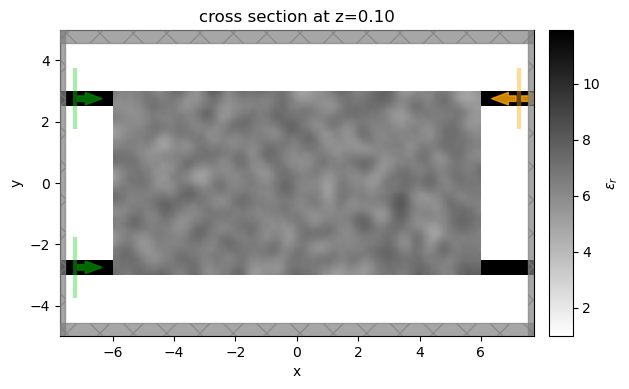

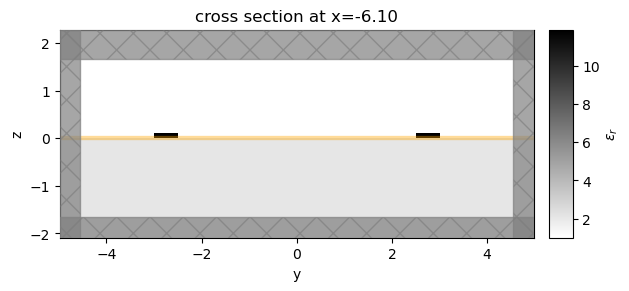

In [43]:
sim_start = make_sim(params0)

ax = sim_start.plot_eps(z=0.1)
ax = sim_start.plot_eps(x=-6.1)

plt.show()


### Select Input and Output Modes

Next, let's visualize the mode profiles so we can inspect which mode indices we want to inject and transmit.

[14:10:53] WARNING: Mode field at frequency index 0, mode index 1 does not decay
           at the plane boundaries.                                             

Effective index of computed modes:  [[1.6596032 1.3548543]]


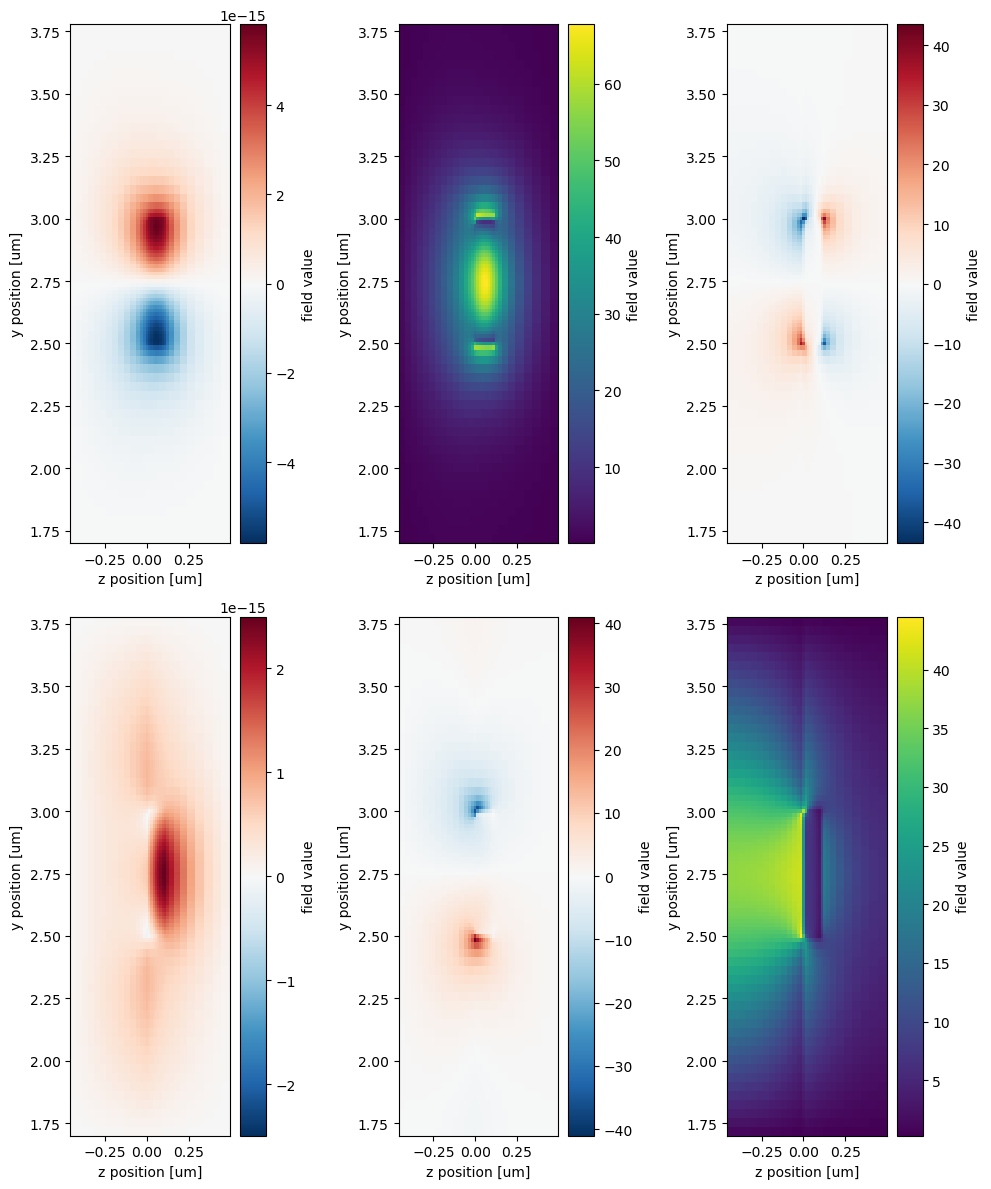

In [45]:
mode_solver = ModeSolver(
    simulation=sim_start, plane=forward_source_top, mode_spec=mode_spec, freqs=[freq0]
)
modes = mode_solver.solve()

print("Effective index of computed modes: ", np.array(modes.n_eff))

fig, axs = plt.subplots(num_modes, 3, figsize=(10, 12), tight_layout=True)
for mode_ind in range(num_modes):
    for field_ind, field_name in enumerate(("Ex", "Ey", "Ez")):
        field = modes.field_components[field_name].sel(mode_index=mode_ind)
        ax = axs[mode_ind, field_ind]
        field.real.plot(ax=ax)
        ax.set_title('')

Aftert inspection, we decide to inject the fundamental, Ey-polarized input into the 1st order Ey-polarized input.

From the plots, we see that these modes correspond to the first and third rows, or `mode_index=0` and `mode_index=1`, respectively. 

So we make sure that the `mode_index_in` and `mode_index_out` variables are set appropriately.

### Post Processing

We will define one more function to tell us how we want to postprocess a `JaxSimulationData` object to give the conversion power that we are interested in maximizing.

In [46]:
def measure_power(sim_data: JaxSimulationData) -> float:
    """Return the power in the output_data amplitude at the mode index of interest."""
    output_amps = sim_data[measurement_monitor_name].amps
    amp = output_amps.sel(direction="+", f=freq0, mode_index=mode_index_out)
    return jnp.sum(jnp.abs(amp) ** 2)


### Define Objective Function

Finally, we need to define the objective function that we want to maximize as a function of our input parameters that returns the conversion power. This is the function we will differentiate later.

In [47]:
def J(params, step_num: int = None, verbose: bool = False) -> float:
    sim = make_sim(params)
    task_name = "inv_des"
    if step_num:
        task_name += f"_step_{step_num}"
    sim_data = run(sim, task_name=task_name, verbose=verbose)
    return measure_power(sim_data), sim_data


## Inverse Design

Now we are ready to perform the optimization.

We use the `jax.value_and_grad` function to get the gradient of `J` with respect to the permittivity of each `Box`, while also returning the converted power associated with the current iteration, so we can record this value for later.

Let's try running this function once to make sure it works.

In [48]:
dJ_fn = value_and_grad(J, has_aux=True)


In [49]:
(val, data), grad = dJ_fn(params0, verbose=True)
print(grad.shape)


[14:12:23] Created task 'inv_des' with task_id                                  
           'fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1'.

           View task using web UI at                                            
           ]8;id=294349;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=166088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\taskId]8;;\]8;id=294349;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\=]8;;\]8;id=952885;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\fdve]8;;\]8;id=294349;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\-31dd5067-18d3-]8;;\
           ]8;id=294349;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\475e-b4d0-c32cbb3278d3v1']8;;\.

Output()

Output()

[14:12:36] status = queued

Output()

[14:12:39] status = preprocess

[14:12:45] Maximum FlexCredit cost: 1.487. Use 'web.real_cost(task_id)' to get  
           the billed FlexCredit cost after a simulation run.

           starting up solver

           running solver

           To cancel the simulation, use 'web.abort(task_id)' or                
           'web.delete(task_id)' or abort/delete the task in the web UI.        
           Terminating the Python script will not stop the job running on the   
           cloud.

Output()

[14:13:57] early shutoff detected, exiting.

[14:13:58] status = postprocess

Output()

[14:14:10] status = success

[14:14:11] View simulation result at                                            
           ]8;id=168008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=358675;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\taskId]8;;\]8;id=168008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\=]8;;\]8;id=818394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\fdve]8;;\]8;id=168008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\-31dd5067-18d3-]8;;\
           ]8;id=168008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-31dd5067-18d3-475e-b4d0-c32cbb3278d3v1\475e-b4d0-c32cbb3278d3v1']8;;\.

Output()

[14:14:29] loading SimulationData from simulation_data.hdf5

[14:14:31] WARNING: 2 sources, using their average 'fwidth' for adjoint source. 

           Created task 'inv_des_adj' with task_id                              
           'fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1'.

           View task using web UI at                                            
           ]8;id=832169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=677295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\taskId]8;;\]8;id=832169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\=]8;;\]8;id=273327;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\fdve]8;;\]8;id=832169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\-107d7f6c-7003-]8;;\
           ]8;id=832169;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\4b71-86bc-9cd64f777861v1']8;;\.

Output()

Output()

[14:14:41] status = queued

Output()

[14:14:45] status = preprocess

[14:14:49] Maximum FlexCredit cost: 1.481. Use 'web.real_cost(task_id)' to get  
           the billed FlexCredit cost after a simulation run.

           starting up solver

           running solver

           To cancel the simulation, use 'web.abort(task_id)' or                
           'web.delete(task_id)' or abort/delete the task in the web UI.        
           Terminating the Python script will not stop the job running on the   
           cloud.

Output()

[14:15:54] early shutoff detected, exiting.

           status = postprocess

Output()

[14:16:05] status = success

           View simulation result at                                            
           ]8;id=22008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=701610;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\taskId]8;;\]8;id=22008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\=]8;;\]8;id=874894;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\fdve]8;;\]8;id=22008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\-107d7f6c-7003-]8;;\
           ]8;id=22008;https://tidy3d.simulation.cloud/workbench?taskId=fdve-107d7f6c-7003-4b71-86bc-9cd64f777861v1\4b71-86bc-9cd64f777861v1']8;;\.

Output()

(600, 300)


In [50]:
val

DeviceArray(0.00195364, dtype=float32)

### Optimization

We will use "Adam" optimization strategy to perform sequential updates of each of the permittivity values in the [JaxCustomMedium](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.adjoint.JaxCustomMedium.html?highlight=JaxCustomMedium#tidy3d.plugins.adjoint.JaxCustomMedium).

For more information on what we use to implement this method, see [this article](https://optimization.cbe.cornell.edu/index.php?title=Adam).

We will run 10 steps and measure both the permittivities and powers at each iteration.

We capture this process in an `optimize` function, which accepts various parameters that we can tweak.

In [51]:
import optax

td.config.logging_level = "ERROR"

# hyperparameters
num_steps = 50
learning_rate = 25e-4

# initialize adam optimizer with starting parameters
params = np.array(params0)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
Js = []
params_history = [params]
data_history = [data]

for i in range(num_steps):

    # compute gradient and current objective funciton value
    (value, data), gradient = dJ_fn(params, step_num=i+1)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")    

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params = optax.apply_updates(params, updates)

    # save history
    Js.append(value)
    params_history.append(params)    
    data_history.append(data)


step = 1
	J = 1.9536e-03
	grad_norm = 2.1686e-01
step = 2
	J = 2.9105e-02
	grad_norm = 6.8190e-01
step = 3
	J = 2.1602e-02
	grad_norm = 4.9284e-01


[14:29:49] ERROR: You do not have enough FlexCredits to run this simulation. You
           may be able to purchase or redeem more FlexCredits, or change your   
           simulation plan from your Account page.                              

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "<frozen runpy>", line 173, in _run_module_as_main
  File "<frozen runpy>", line 65, in _run_code
  File "/home/satadrudas/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 0, in <module>
  File "/home/satadrudas/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 984, in launch_instance
    @classmethod
    
  File "/home/satadrudas/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 693, in start
    def start(self):
    
  File "/home/satadrudas/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 194, in start
    def start(self) -> None:
    
  File "/home/satadrudas/anaconda3/lib/python3.11/asyncio/base_events.py", line 593, in run_forever
    def run_forever(self):
    
  File "/home/satadrudas/anaconda3/lib/python3.11/asyncio/base_events.py", line 1845, in _run_once
    def _run_once(self):
    
  File "/home/satadrudas/anaconda3/lib/python3.11/asyncio/eve

In [52]:
params_after = params_history[-1]

### Results

First, we plot the objective function as a function of step and notice that it converges nicely!

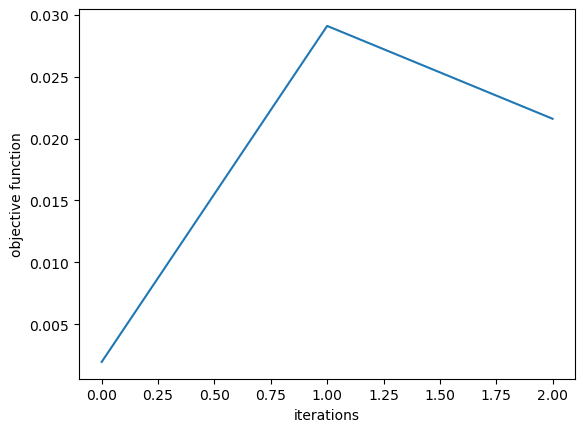

In [53]:
plt.plot(jnp.array(Js))
plt.xlabel("iterations")
plt.ylabel("objective function")

plt.show()


In [54]:
Js

[DeviceArray(0.00195364, dtype=float32),
 DeviceArray(0.02910472, dtype=float32),
 DeviceArray(0.02160156, dtype=float32)]

In [55]:
print(f"Initial power conversion = {Js[0]*100:.2f} %")
print(f"Final power conversion = {Js[-1]*100:.2f} %")


Initial power conversion = 0.20 %
Final power conversion = 2.16 %


We then will visualize the final structure, so we convert it to a regular `Simulation` using the final permittivity values and plot it.

In [56]:
sim_final = make_sim(params_after)


In [57]:
sim_data_final = data_history[-1]
sim_final = sim_data_final.simulation

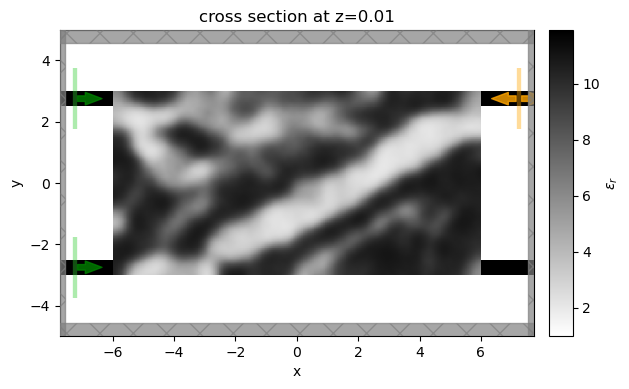

In [58]:
sim_final = sim_final.to_simulation()[0]
sim_final.plot_eps(z=0.01)
plt.show()

Finally, we want to inspect the fields, so we add a field monitor to the `Simulation` and perform one more run to record the field values for plotting.

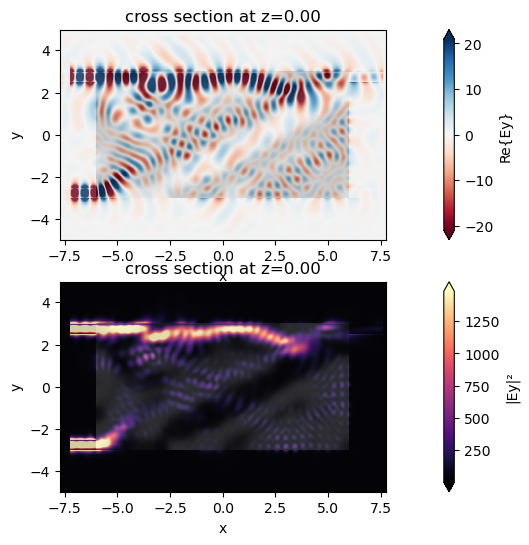

In [59]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))
ax1 = sim_data_final.plot_field("field", "Ey", z=0, ax=ax1)
ax2 = sim_data_final.plot_field("field", "Ey", "abs^2", z=0, ax=ax2)

plt.show()

In [60]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=False, figsize=(8, 4))

def animate(i):

    # grab data at iteration "i"
    sim_data_i = data_history[i]

    # plot permittivity
    sim_i = sim_data_i.simulation.to_simulation()[0]
    sim_i.plot_eps(z=lz/2, monitor_alpha=0.0, source_alpha=0.0, ax=ax1)
    # ax1.set_aspect('equal')
    
    # plot intensity
    # int_i = sim_data_i.get_intensity("field")
    # int_i.squeeze().plot.pcolormesh(x='x', y='y', ax=ax2, add_colorbar=True, cmap="magma")
    abs(sim_data_i["field"].Ey**2).plot(x='x', y='y', ax=ax2, add_colorbar=False, cmap="magma")
    # ax2.set_aspect('equal')
    
# create animation
ani = animation.FuncAnimation(fig, animate, frames=len(data_history));
plt.close()

# display the animation (press "play" to start)
HTML(ani.to_jshtml())


<Figure size 640x480 with 0 Axes>

In [34]:
ani.save('animation_best.gif', writer='imagemagick', fps=60)

MovieWriter imagemagick unavailable; using Pillow instead.


<Figure size 640x480 with 0 Axes>